In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
regressor_performance_df = pd.read_excel("performance_excels/regressor_performance.xlsx")
labelranking_performance_df = pd.read_excel("performance_excels/rpc_performance.xlsx")
# baseline_performance_df = pd.read_excel("performance_excels/regressor_performance.xlsx")

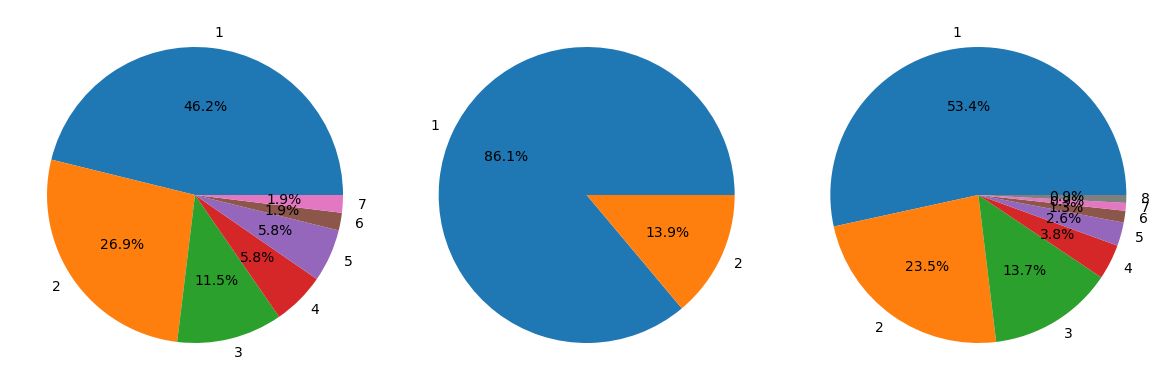

In [3]:
fig, ax = plt.subplots(ncols=3, tight_layout=True, figsize=(12,4))

for i, oos in enumerate(["halide", "additive", "both"]) :
    ranks = regressor_performance_df[
        regressor_performance_df["OOS"] == oos
    ]["Top Rank"]
    sizes = [len(np.where(ranks == x)[0]) for x in sorted(ranks.unique())]
    labels = sorted(ranks.unique())
    ax[i].pie(sizes, labels=labels, autopct='%1.1f%%')
    # ax[i].set_title(f"{oos} out-of-training-sample")

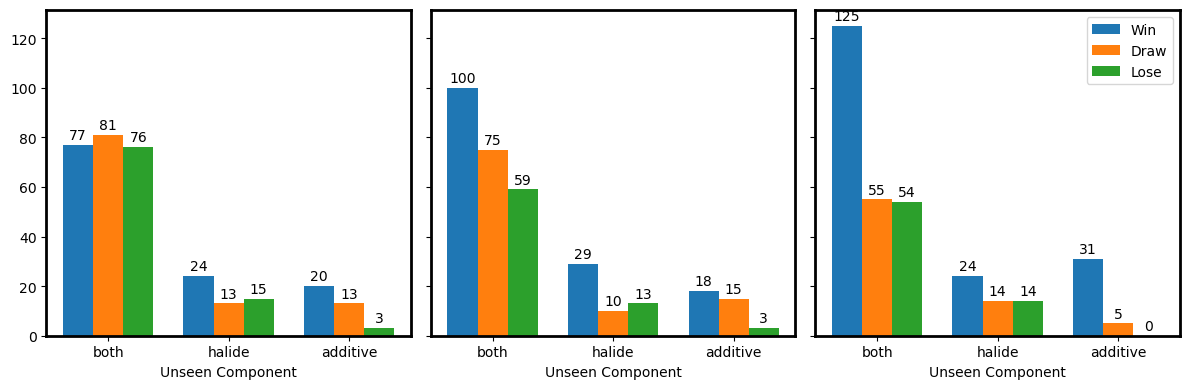

In [5]:
oos_choices = ["both","halide","additive"]

x = np.arange(3)

fig, ax = plt.subplots(ncols=3, figsize=(12,4), tight_layout=True, sharey=True)
for j, model in enumerate(["Pairwise", "LBRF", "LRT"]):
    regressor_w_d_l = np.zeros((3,3))
    for i, row in labelranking_performance_df[labelranking_performance_df["Model"]==model].iterrows():
        halide = row["Test halide"]
        additive = row["Test additive"]
        oos = row["OOS"]

        rpc_top_rank = row["Top Rank"]
        regressor_top_rank = regressor_performance_df[
            (regressor_performance_df["Test halide"] == halide) &\
            (regressor_performance_df["Test additive"] == additive) &\
            (regressor_performance_df["OOS"] == oos)
        ]["Top Rank"].values
        assert len(regressor_top_rank) ==1
        regressor_top_rank = regressor_top_rank[0]
        # print(rpc_top_rank, regressor_top_rank)

        if regressor_top_rank < rpc_top_rank :
            regressor_w_d_l[oos_choices.index(oos), 0] += 1
        elif regressor_top_rank == rpc_top_rank :
            regressor_w_d_l[oos_choices.index(oos), 1] += 1
        else : 
            regressor_w_d_l[oos_choices.index(oos), 2] += 1

    width=0.25
    multiplier = 0
    for oos_ind, measure in enumerate(regressor_w_d_l) :
        offset = width * multiplier
        rects = ax[j].bar(x + offset, regressor_w_d_l[:, oos_ind].flatten(), width)
        ax[j].bar_label(rects, padding=2)
        multiplier += 1
    ax[j].set_xticks(x+width, oos_choices)
    ax[j].set_xlabel("Unseen Component")
    if j == 2 :
        ax[j].legend(["Win", "Draw", "Lose"], loc="upper right")
    for axis in ['top', 'bottom', 'left', 'right']:
        ax[j].spines[axis].set_linewidth(2)

In [6]:
regressor_performance_df = pd.read_excel("performance_excels/regressor_performance_20.xlsx")
labelranking_performance_df = pd.read_excel("performance_excels/rpc_performance_20.xlsx")
baseline_performance_df = pd.read_excel("performance_excels/baseline_performance_20.xlsx")

swarmplot_dict = {
    "Model":[],
    "RFR":[],
    "Count":[],
    "OOS":[]
}
baseline_dict = {
    "RFR":[],
    "Count":[],
    "OOS":[]
}
train_halide_additive_pairs = list(set([(x,y) for (x,y) in list(labelranking_performance_df[["Train halides", "Train additives"]].itertuples(index=False, name=None))]))
print(len(train_halide_additive_pairs))
# uniq_train_halides = labelranking_performance_df["Train halides"].unique()
# uniq_train_additives = labelranking_performance_df["Train additives"].unique()

for j, model in enumerate(["Pairwise", "LBRF", "LRT"]):
    for (halide_tuple, additive_tuple) in train_halide_additive_pairs:
        category_counts = np.zeros((3,3)) # each row: OOS / each col: win, draw, lose
        baseline_counts = np.zeros((3,3))
        for i, row in labelranking_performance_df[
            (labelranking_performance_df["Model"]==model) &\
            (labelranking_performance_df["Train halides"]==halide_tuple) &\
            (labelranking_performance_df["Train additives"]==additive_tuple)
        ].iterrows():
            halide = row["Test halide"]
            additive = row["Test additive"]
            oos = row["OOS"]

            lr_top_rank = row["Top Rank"]
            regressor_top_rank = regressor_performance_df[
                (regressor_performance_df["Test halide"] == halide) &\
                (regressor_performance_df["Test additive"] == additive) &\
                (regressor_performance_df["OOS"] == oos)&\
                (regressor_performance_df["Train halides"]==halide_tuple) &\
                (regressor_performance_df["Train additives"]==additive_tuple)
            ]["Top Rank"].values
            baseline_top_rank = baseline_performance_df[
                (baseline_performance_df["Test halide"] == halide) &\
                (baseline_performance_df["Test additive"] == additive) &\
                (baseline_performance_df["OOS"] == oos)&\
                (baseline_performance_df["Train halides"]==halide_tuple) &\
                (baseline_performance_df["Train additives"]==additive_tuple)
            ]["Top Rank"].values
            assert len(regressor_top_rank) == 1
            regressor_top_rank = regressor_top_rank[0]
            baseline_top_rank = baseline_top_rank[0]
            # print(rpc_top_rank, regressor_top_rank)

            if regressor_top_rank < lr_top_rank :
                category_counts[oos_choices.index(oos), 0] += 1
            elif regressor_top_rank == lr_top_rank :
                category_counts[oos_choices.index(oos), 1] += 1
            else : 
                category_counts[oos_choices.index(oos), 2] += 1

            if regressor_top_rank < baseline_top_rank :
                baseline_counts[oos_choices.index(oos), 0] += 1
            elif regressor_top_rank == baseline_top_rank :
                baseline_counts[oos_choices.index(oos), 1] += 1
            else : 
                baseline_counts[oos_choices.index(oos), 2] += 1

        swarmplot_dict["Model"].extend([model]*9)
        swarmplot_dict["RFR"].extend(["Win", "Draw", "Lose"]*3)
        swarmplot_dict["Count"].extend(list(category_counts.flatten()))
        swarmplot_dict["OOS"].extend(["both","both","both","halide","halide","halide","additive","additive","additive"])

        baseline_dict["RFR"].extend(["Win", "Draw", "Lose"]*3)
        baseline_dict["Count"].extend(list(baseline_counts.flatten()))
        baseline_dict["OOS"].extend(["both","both","both","halide","halide","halide","additive","additive","additive"])

20


/opt/miniconda3/envs/label/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 20.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


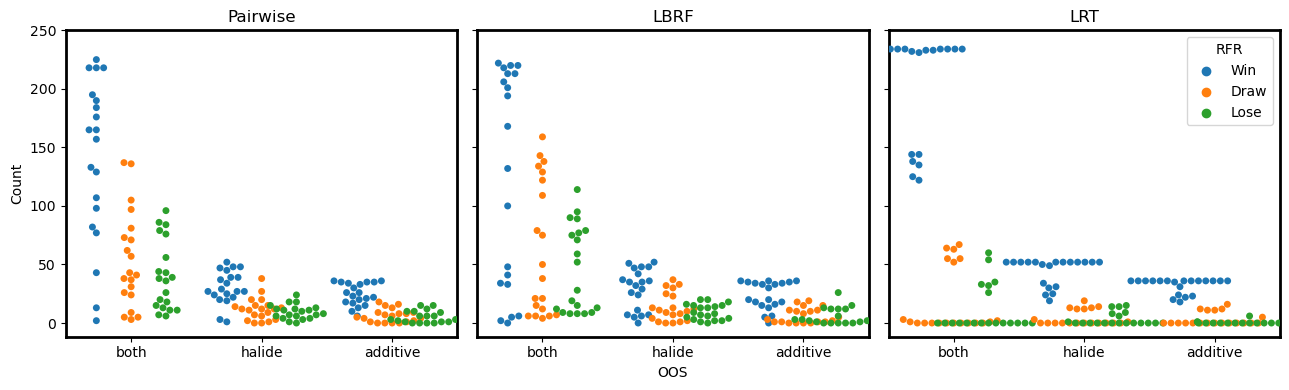

In [7]:
swarmplot_df = pd.DataFrame(swarmplot_dict)

fig, ax = plt.subplots(ncols=3, sharey=True, tight_layout=True, figsize=(13,4))
for j, model in enumerate(["Pairwise", "LBRF", "LRT"]):
    if j!=2 : legend=False
    else : legend=True
    sns.swarmplot(
        data=swarmplot_df.loc[swarmplot_df["Model"]==model, :],
        x="OOS",
        y="Count",
        hue="RFR",
        dodge=True,
        legend=legend,
        ax=ax[j]
    )
    ax[j].set_yticks([50*x for x in np.arange(6)])
    ax[j].set_title(model)
    if j == 0 :
        ax[j].set_yticklabels([50*x for x in np.arange(6)])
    if j!=1 :
        ax[j].set_xlabel("")
    for axis in ['top', 'bottom', 'left', 'right']:
        ax[j].spines[axis].set_linewidth(2)

In [9]:
top_ranks_by_oos = [np.zeros((3,234,20)), np.zeros((3,52,20)), np.zeros((3,36,20))] # first axis : models // second axis : test reactant pair // third axis : training dataset

for k, (halide_tuple, additive_tuple) in enumerate(train_halide_additive_pairs):
    oos_counts = [0, 0, 0]    
    for j, row in regressor_performance_df[
        (regressor_performance_df["Train halides"]==halide_tuple) &\
        (regressor_performance_df["Train additives"]==additive_tuple)
    ].iterrows():
        halide = row["Test halide"]
        additive = row["Test additive"]
        oos = row["OOS"]
        top_ranks = [row["Top Rank"]] # in the order of RF, Pairwise, LBRF
        for i, model in enumerate(["Pairwise", "LBRF"]):
            top_ranks.append(labelranking_performance_df[
                (labelranking_performance_df["Test halide"] == halide) &\
                (labelranking_performance_df["Test additive"] == additive) &\
                (labelranking_performance_df["OOS"] == oos)&\
                (labelranking_performance_df["Train halides"]==halide_tuple) &\
                (labelranking_performance_df["Train additives"]==additive_tuple)&\
                (labelranking_performance_df["Model"]==model)
            ]["Top Rank"].values[0])
        top_ranks_by_oos[oos_choices.index(oos)][:,oos_counts[oos_choices.index(oos)],k] = np.array(top_ranks)
        oos_counts[oos_choices.index(oos)] += 1

In [10]:
from scipy.stats import friedmanchisquare

for i, top_rank_array in enumerate(top_ranks_by_oos) :
    avg = np.mean(top_rank_array, axis=1)
    print(avg.shape)
    _, p = friedmanchisquare(avg[0,:].flatten(), avg[1,:].flatten(), avg[2,:].flatten())
    print(p)
    print()


(3, 20)
0.14227407158651317

(3, 20)
0.001580522168736213

(3, 20)
6.175672433276865e-05



/opt/miniconda3/envs/label/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 8.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/miniconda3/envs/label/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 16.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/miniconda3/envs/label/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 26.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/miniconda3/envs/label/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 33.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


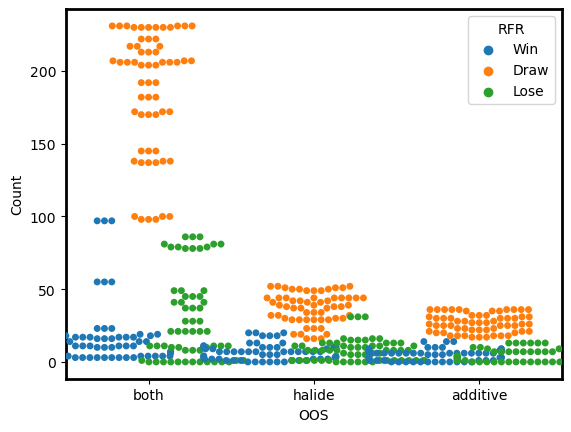

In [12]:
baseline_vs_regressor_df = pd.DataFrame(baseline_dict)

fig, ax = plt.subplots()
sns.swarmplot(
    data=baseline_vs_regressor_df,
    x="OOS",
    y="Count",
    hue="RFR",
    dodge=True,
    legend=legend,
)
# ax[j].set_yticks([50*x for x in np.arange(6)])
# ax[j].set_title(model)
# if j == 0 :
#     ax[j].set_yticklabels([50*x for x in np.arange(6)])
# if j!=1 :
#     ax[j].set_xlabel("")
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(2)

## Visualization of datset

In [50]:
from evaluate_complete_doyle import *

raw_data = pd.read_csv(
    "datasets/doyle_data/Doyle_raw_data.csv",
    usecols=["aryl_halide", "ligand", "base", "additive", "yield"],
)
org_data = pd.pivot_table(
    raw_data,
    values="yield",
    index=["aryl_halide", "additive"],
    columns=["ligand", "base"],
)
# Putting 0% yield as results for those missing results
org_data.fillna(0, inplace=True)

[Text(0, 0.5, ''),
 Text(0, 2.5, ''),
 Text(0, 4.5, ''),
 Text(0, 6.5, ''),
 Text(0, 8.5, ''),
 Text(0, 10.5, ''),
 Text(0, 12.5, ''),
 Text(0, 14.5, ''),
 Text(0, 16.5, ''),
 Text(0, 18.5, ''),
 Text(0, 20.5, ''),
 Text(0, 22.5, ''),
 Text(0, 24.5, ''),
 Text(0, 26.5, ''),
 Text(0, 28.5, ''),
 Text(0, 30.5, ''),
 Text(0, 32.5, ''),
 Text(0, 34.5, ''),
 Text(0, 36.5, ''),
 Text(0, 38.5, ''),
 Text(0, 40.5, ''),
 Text(0, 42.5, ''),
 Text(0, 44.5, ''),
 Text(0, 46.5, ''),
 Text(0, 48.5, ''),
 Text(0, 50.5, ''),
 Text(0, 52.5, ''),
 Text(0, 54.5, ''),
 Text(0, 56.5, ''),
 Text(0, 58.5, ''),
 Text(0, 60.5, ''),
 Text(0, 62.5, ''),
 Text(0, 64.5, ''),
 Text(0, 66.5, ''),
 Text(0, 68.5, ''),
 Text(0, 70.5, ''),
 Text(0, 72.5, ''),
 Text(0, 74.5, ''),
 Text(0, 76.5, ''),
 Text(0, 78.5, ''),
 Text(0, 80.5, ''),
 Text(0, 82.5, ''),
 Text(0, 84.5, ''),
 Text(0, 86.5, ''),
 Text(0, 88.5, ''),
 Text(0, 90.5, ''),
 Text(0, 92.5, ''),
 Text(0, 94.5, ''),
 Text(0, 96.5, ''),
 Text(0, 98.5, ''),
 Text

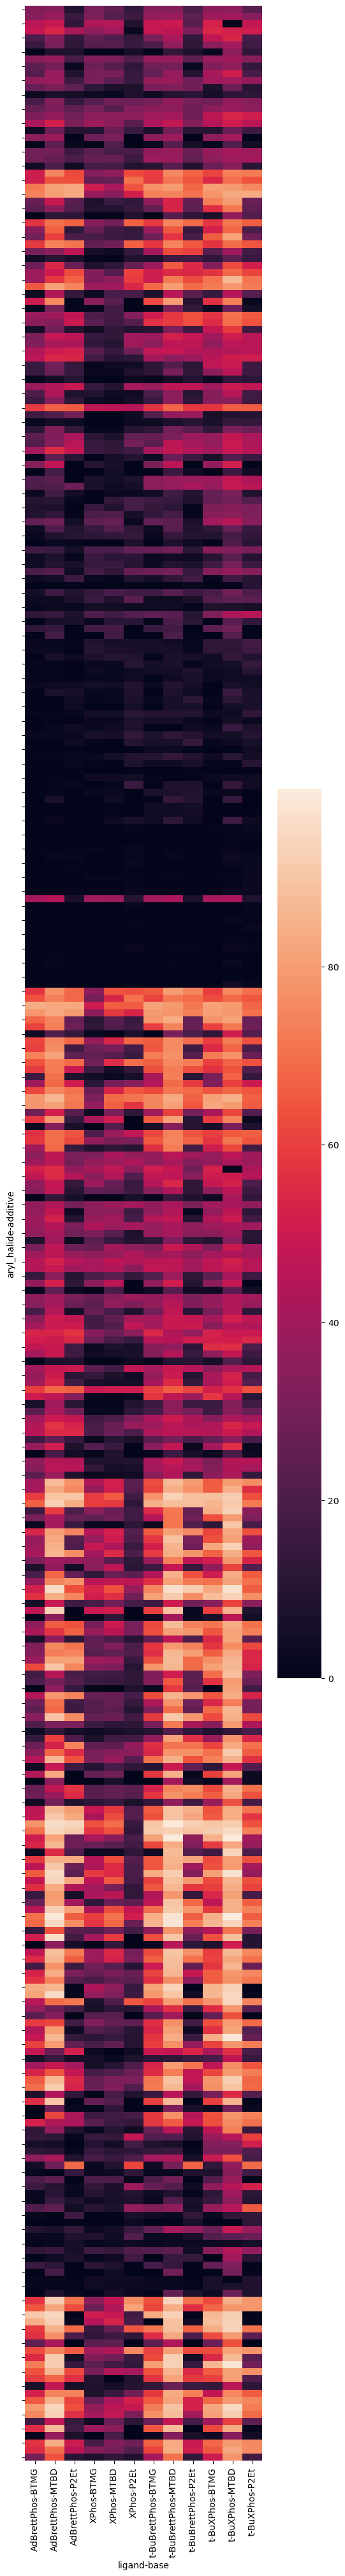

In [43]:
fig, ax = plt.subplots(figsize=(6,50))
sns.heatmap(org_data)
ax.set_yticklabels([])


In [44]:
org_data_array = org_data.to_numpy()
print(org_data_array.shape)

(345, 12)


In [58]:
rank_array = yield_to_ranking(org_data_array)
portion_top_2 = []
for i in range(12) :
    portion_top_2.append(100*len(np.where(rank_array[:,i] <= 2)[0])/345)

print(portion_top_2)
print(sum(portion_top_2))

Raw rank (345, 12)
[0.2898550724637681, 33.04347826086956, 5.507246376811594, 0.8695652173913043, 0.2898550724637681, 7.536231884057971, 0.8695652173913043, 50.14492753623188, 5.217391304347826, 12.173913043478262, 66.66666666666667, 16.52173913043478]
199.13043478260872


In [70]:
np.argpartition(org_data_array, axis=1, kth=-2)[:,-2:]

array([[ 9, 10],
       [ 9, 10],
       [ 7,  9],
       [ 1,  9],
       [ 9, 10],
       [ 7, 10],
       [ 7, 10],
       [ 7, 10],
       [ 9, 10],
       [ 9, 10],
       [ 9, 10],
       [ 1,  7],
       [10, 11],
       [ 7, 10],
       [11, 10],
       [11, 10],
       [10,  1],
       [10,  7],
       [ 7, 10],
       [ 7,  1],
       [11, 10],
       [10, 11],
       [ 9, 10],
       [ 1,  7],
       [ 5,  7],
       [ 1,  2],
       [10, 11],
       [ 9, 10],
       [ 9, 10],
       [ 7, 10],
       [10,  7],
       [ 1, 10],
       [ 9, 10],
       [ 1,  7],
       [ 8,  7],
       [ 7, 10],
       [10,  7],
       [ 2, 10],
       [ 7, 10],
       [ 7,  1],
       [10,  7],
       [ 1,  7],
       [ 1,  7],
       [11, 10],
       [11, 10],
       [ 9, 10],
       [10,  7],
       [10,  8],
       [ 1,  2],
       [ 2,  1],
       [ 9, 10],
       [ 9, 10],
       [11, 10],
       [ 2, 10],
       [ 1, 10],
       [10,  7],
       [ 1,  7],
       [ 7,  8],
       [11, 10

ligand                                                                             AdBrettPhos  \
base                                                                                      BTMG   
aryl_halide                        additive                                                      
1-bromo-4-(trifluoromethyl)benzene 3,5-dimethylisoxazole                             33.308418   
                                   3-methyl-5-phenylisoxazole                        33.601740   
                                   3-methylisoxazole                                 45.929801   
                                   3-phenylisoxazole                                 48.067865   
                                   4-phenylisoxazole                                 19.847941   
...                                                                                        ...   
3-iodopyridine                     ethyl-isoxazole-3-carboxylate                     55.789518   
                                   ethyl-isoxazole-4-carboxylate                      1.409596   
                                   methyl-5-(furan-2-yl)isoxazole-3-carboxylate      57.246247   
                                   methyl-5-(thiophen-2-yl)isoxazole-3-carboxylate   55.264663   
                                   methyl-isoxazole-5-carboxylate                    29.297642   

ligand                                                                                         \
base                                                                                     MTBD   
aryl_halide                        additive                                                     
1-bromo-4-(trifluoromethyl)benzene 3,5-dimethylisoxazole                            33.950376   
                                   3-methyl-5-phenylisoxazole                       37.935670   
                                   3-methylisoxazole                                49.153722   
                                   3-phenylisoxazole                                53.854572   
                                   4-phenylisoxazole                                33.220332   
...                                                                                       ...   
3-iodopyridine                     ethyl-isoxazole-3-carboxylate                    86.792602   
                                   ethyl-isoxazole-4-carboxylate                    37.085431   
                                   methyl-5-(furan-2-yl)isoxazole-3-carboxylate     83.955606   
                                   methyl-5-(thiophen-2-yl)isoxazole-3-carboxylate  69.795902   
                                   methyl-isoxazole-5-carboxylate                   63.990722   

ligand                                                                                         \
base                                                                                     P2Et   
aryl_halide                        additive                                                     
1-bromo-4-(trifluoromethyl)benzene 3,5-dimethylisoxazole                             9.025274   
                                   3-methyl-5-phenylisoxazole                       15.469297   
                                   3-methylisoxazole                                12.616967   
                                   3-phenylisoxazole                                41.593262   
                                   4-phenylisoxazole                                13.524201   
...                                                                                       ...   
3-iodopyridine                     ethyl-isoxazole-3-carboxylate                    16.772023   
                                   ethyl-isoxazole-4-carboxylate                     7.121203   
                                   methyl-5-(furan-2-yl)isoxazole-3-carboxylate     50.259370   
                                   methyl-5-(thiophen-2-yl)isoxazole-3-carboxylate  45.770461   
       

In [52]:
all_zero_count = 0
for row in org_data_array:
    if sum(row) == 0 :
        all_zero_count +=1
print(all_zero_count)

1


In [ ]:
pd.pivot_table(
        raw_data,
        values="yield",
        index=["aryl_halide", "additive", "base"],
        columns=["ligand"],
    )